In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import useful_functions as uf
import density as den
import constants as cc
from scipy.interpolate import interp1d
import sys
sys.path.insert(0,'/home/zahra/hirax_tools/hirax_tools')
from array_config import HIRAXArrayConfig
from scipy.integrate import trapz
import pylab
from matplotlib.colors import LogNorm


In [2]:
cosmo=uf.cosmo

Mps_interpf=uf.Mps_interpf

n_points=20
n=n_points
z_r=10

x_e=1.

G=cc.G_const_Mpc_Msun_s/cc.M_sun_g

#rho_c=3*H0**2/(8.*np.pi*G)

rho_c=den.cosmo_densities(**cosmo)[0]*cc.M_sun_g #in units of g/Mpc^3

sigma_T=cc.sigma_T_Mpc

tau_r=0.055

T_rad=2.725 #In Kelvin
#tau_r=0.046*omega_b_0*h*x_e[np.sqrt(omega_M_0(1+z_r)**3+(1-omega_M_0))-1]

#get matter power spec data

mu_e=1.14

m_p=cc.m_p_g #in grams

rho_g0=cosmo['omega_b_0']*rho_c

#plt.loglog(uf.kabs,Mps_interpf(uf.kabs))

#plt.show()
zed=uf.zed

H=uf.H
chi=uf.chi
#chi_Z=chi(Z)
tau_inst=uf.tau_inst
f=uf.f
D=uf.D_1
r=uf.r
z_c=1.
delta_z=0.2

kperp_lims=uf.ell_lims(z_c,6.,1024*6.)/uf.chi(z_c)
kpar_min_lim=uf.kpar_min(z_c,delta_z)

#kpperp_min=kperp_lims[0]
#kpperp_max=kperp_lims[1]
kpperp_min=5.e-4
kpperp_max=10.
kppar_min=1.e-6
kppar_max=1.

In [3]:
ell=np.geomspace(2.,1.e4,n_points)
kperp_arr=ell/chi(z_c)
kpar_arr=np.geomspace(kppar_min,kppar_max,n_points)
y=kpar_arr*r(z_c)


In [4]:

#kpar_min=uf.kpar_min(z,delta_z)

def ionized_elec(Yp,N_He):

    x=(1-Yp*(1-N_He/4))/(1-Yp/2)

    return x


x=ionized_elec(0.24,0)


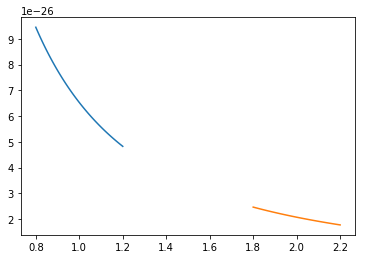

2.690253963164062e-26
8.372406276000352e-27


In [5]:
z_min=z_c-delta_z
z_max=z_c+delta_z
z_2=np.geomspace(1.8,2.2,100)
z_1=np.geomspace(0.8,1.2,100)

nu_21=1420
nu_min=nu_21/(1+z_max) #743. #585. # #freq in MHz, these min and max values are based on HIRAX
nu_max=nu_21/(1+z_min)#784. #665. #

delta_nu_tilde=(nu_max-nu_min)/nu_21

def redshift_21cm_terms(z_21,kpar,kperp):
    k=np.sqrt(kpar**2+kperp**2)
    rsd=1.+f(z_21)*kpar**2/k**2
    redshift_21cm=uf.T_mean(z_21)**2*f(z_21)*D(z_21)**2*H(z_21)*rsd**2/(chi(z_21)**2*r(z_21))/(1.+z_21)
    return redshift_21cm

kpar=1.e-1
kperp=10.

#delta_21=T_mean_z1*rsd*D_z1
plt.plot(z_1,redshift_21cm_terms(z_1,kpar,kperp))
plt.plot(z_2,redshift_21cm_terms(z_2,kpar,kperp))
plt.show()

print trapz(redshift_21cm_terms(z_1,kpar,kperp),z_1)
print trapz(redshift_21cm_terms(z_2,kpar,kperp),z_2)

In [6]:
loaded_fourier_arr=np.load('nu_and_kpar_fourier_dchi2_int_full_redshift_10000pts.npy')

nu=loaded_fourier_arr[0,:]
f_of_kpar_func=loaded_fourier_arr[1,:]

kpar_fourier_dchi2_int=interp1d(nu,f_of_kpar_func)

def crosscorr_fourier(ell,z,y, delta_z,kp_perp,kp_par): #with the assumption that zi=z so no cos factor, and we have dz=redshift bin width=2*delta_z defined above
    n=n_points #number of points over which to integrate
    #y=np.geomspace(1.,3000.,n)
    T_mean_zi=uf.T_mean(z)
    chi_zi=chi(z)
    f_zi=uf.f(z)
    D_zi=uf.D_1(z)
    r_zi=uf.r(z)
    H_zi=uf.H(z)
    kpar=y/uf.r(z)
    const=1.e6/(4.*np.pi**2)*T_rad*T_mean_zi**2/cc.c_light_Mpc_s*f_zi*D_zi**2*H_zi/(chi_zi**2*r_zi)/(1.+z)*x*(sigma_T*rho_g0/(mu_e*m_p))
    #Cl=np.array([])
    k_perp=ell/chi_zi
    k=np.sqrt(k_perp**2+kpar**2)
    rsd=1.+f_zi*kpar**2/k**2
    kp=np.sqrt(kp_perp**2+kp_par**2)
    cos_theta=kp_par/kp #cos_theta=u, theta is azimuthal angle between k' and z (line of sight) axis
    sin_theta=kp_perp/kp
    sin_gamma=kpar/k #gamma is measured between k and xy plane, i.e. elevation of k
    cos_gamma=k_perp/k
    zeta=sin_gamma*cos_theta+cos_gamma*sin_theta
    k_dot_kp=k_perp*kp_perp+kpar*kp_par#*zeta
    k_perp_dot_kp_perp=k_perp*kp_perp
    K=np.sqrt(k**2+kp**2-2*k_dot_kp)
    K_perp=np.sqrt(np.abs(k_perp**2+kp_perp**2-2*k_perp_dot_kp_perp))
    #theta_K=kpar/K/k**2*(k**2-k_dot_kp)-kp*k_perp*np.sqrt(np.abs(1-zeta**2))/k/K
    theta_K=(np.abs(kpar-kp_par))/K
    theta_kp=cos_theta
    z_integral=np.abs(kpar_fourier_dchi2_int(kpar))
    #theta_kp=kpar*zeta/k+k_perp*np.sqrt(np.abs(1-zeta**2))/k
    #print (theta_K.min(),theta_K.max())
    #theta_K=np.where(theta_K > 0, theta_K, 0)
    I=theta_kp*(theta_kp/kp**2+theta_K/K/kp)
    #z_integral=sp.integrate.trapz(f_z*D_z**2*(1+z)*np.exp(-tau_z)*np.cos(kpar*cc.c_light_Mpc_s*z/H_z),z)
    integrand_1=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp**2*kp_perp/kp**2
  #+theta_K/K/kp)#-mu*kp*np.gradient(Mps_interpf(k),axis=0))
    integrand_2=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp*theta_K*kp_perp/kp/K

    #Cl=np.append(Cl,integral)
    return const*(integrand_1+integrand_2)



In [7]:
def Func_2d_redshift(ell,z_arr,y,Func,delta_z):
    Func_mat=np.zeros((len(ell),len(y),len(z_arr)))
    for i in range(len(ell)):
        for j in range(len(y)):
            for z_ind in range(len(z_arr)):
                Func_ind=Func(ell[i],z_arr[z_ind],y[j],delta_z)
                Func_mat[i][j][z_ind]=Func_ind
    return Func_mat


def Func_noise_redshift_slow(ell,z_arr,y,Func,delta_z,Noise):
    Func_mat=np.zeros((len(ell),len(y),len(z_arr)))
    for i in range(len(ell)):
        for j in range(len(y)):
            for z_ind in range(len(z_arr)):
                Func_ind=Func(ell[i],z_arr[z_ind],y[j],delta_z,Noise)
                Func_mat[i][j][z_ind]=Func_ind       
    return Func_mat

def Func_noise_redshift_fast(ell,z_arr,y,Func,delta_z,Noise):
    Func_mat=[Func(ell[i],z_arr[z_ind],y[j],delta_z,Noise) 
        for i in range(len(ell))
        for j in range(len(y))
        for z_ind in range(len(z_arr))]
    return Func_mat


def Func_2d(ell,z_c,y,Func,delta_z):
    Func_mat=np.zeros((len(ell),len(y)))
    for i in range(len(ell)):
        for j in range(len(y)):
            Func_ind=Func(ell[i],z_c,y[j],delta_z)
            Func_mat[i][j]=Func_ind
    return Func_mat


def Func_noise(ell,z_c,y,Func,delta_z,Noise):
    Func_mat=np.zeros((len(ell),len(y)))
    for i in range(len(ell)):
        for j in range(len(y)):
            Func_ind=Func(ell[i],z_c,y[j],delta_z,Noise)
            Func_mat[i][j]=Func_ind
    return Func_mat


def Signal_integrated_fourier(ell,z,y,delta_z):
    Kp_perp=np.geomspace(kpperp_min,kpperp_max,n)
    Kp_par=np.geomspace(kppar_min,kppar_max,n)
    kp_perp,kp_par=np.meshgrid(Kp_perp,Kp_par)
    B=crosscorr_fourier(ell,z,y, delta_z,kp_perp,kp_par)
    integral=trapz(trapz(B,Kp_perp,axis=0),Kp_par,axis=0)
    integral_sqrt=np.sqrt(np.abs(integral))
    return integral


In [8]:
def C_l_mu_integral(ell,z_min):
    Kp=np.geomspace(1.e-10,10.,n_points)
    Mu=np.linspace(-0.9999,0.9999,n_points)
    Z=np.geomspace(z_min,10,n_points)
    mu,kp,z=np.meshgrid(Mu,Kp,Z)
    H_z=uf.H(z)
    chi_z=uf.chi(z)
    #chi_Z=chi(Z)
    tau_z=uf.tau_inst(z)
    f_z=uf.f(z)
    D_z=uf.D_1(z)
    const=1e12*T_rad**2*x**2/cc.c_light_Mpc_s*(sigma_T*rho_g0/(mu_e*m_p))**2/8/np.pi**2
    #kp_norm=np.linalg.norm(Kp)
    #k_norm=np.linalg.norm(ell/chi_Z)
    theta_kp_arr=np.array([])
    theta_K_arr=np.array([])
    I_arr=np.array([])
    C_l=np.array([])
    for i in ell:
        k=i/chi_z
        K=np.sqrt(k**2+kp**2-2*k*kp*mu)
        theta_kp=np.sqrt(1-mu**2)
        theta_K=-np.sqrt(1-mu**2)*kp/K
        theta_kp_arr=np.append(theta_kp_arr,theta_kp)
        theta_K_arr=np.append(theta_K_arr,theta_K)
        I=theta_kp**2/kp**2+theta_K*theta_kp/K/kp
        I_arr=np.append(I_arr,I)
        #I=k*(k-2*kp*mu)*(1-mu**2)/K**2
        integral=[const*sp.integrate.trapz(sp.integrate.trapz(sp.integrate.trapz(kp**2*I*Mps_interpf(kp)*Mps_interpf(K)*(1+z)**2*np.exp(-2*tau_z)
        *f_z**2*D_z**4/chi_z**2*H_z,Mu,axis=0),Kp,axis=0),Z,axis=0)]
        C_l=np.append(C_l,integral)
    return C_l, theta_kp_arr, theta_K_arr, I_arr


In [9]:
ell_large=np.geomspace(2.,1.e5,100)
#np.save('C_l_ksz_z_1_full_100pts_2d_2_1e5.npy',(ell_large,C_l_mu_integral(ell_large,1.e-4)[0]))


In [10]:
Cl_ksz=np.load('C_l_ksz_z_1_full_100pts_2d_2_1e5.npy')
ell_loaded=Cl_ksz[0,:]
Cl_ksz_full_arr=Cl_ksz[1,:]
OV_interp=interp1d(ell_loaded,Cl_ksz_full_arr)

In [11]:

ell_large=np.geomspace(2.,1.e5,50000)
#np.save('cmb_spec_2_1e5_50000pts',(ell_large,cmb_spec(ell_large)))
#np.save('cmb_noise_2_1e5_50000pts',(ell_large,cmb_noise(ell_large)))
cmb_spec=np.load('cmb_spec_2_1e5_50000pts.npy')
cmb_noise=np.load('cmb_noise_2_1e5_50000pts.npy')
ell_cmb=cmb_spec[0,:]
cmb_spec_loaded=cmb_spec[1,:]
cmb_noise_loaded=cmb_noise[1,:]

cmb_spec_interp=interp1d(ell_cmb,cmb_spec_loaded)
cmb_noise_interp=interp1d(ell_cmb,cmb_noise_loaded)

In [12]:
def HiraxNoise(l,Ddish,Dsep,zi,delta_z): #the Dsep refers to the dish seperation including the dish diameter of 6. So we're assuming dishes are 1m away
        z_min=zi-delta_z
        z_max=zi+delta_z
        nu_21=1420
        nu_min=nu_21/(1+z_max) #743. #585. # #freq in MHz, these min and max values are based on HIRAX
        nu_max=nu_21/(1+z_min)#784. #665. #
        cp= HIRAXArrayConfig.from_n_elem_compact(1024,Dsep)
        nubar=(nu_min+nu_max)/2.

        Fov_deg=(cp.fov(frequency=nubar)) * ((180./np.pi)**2)
        Fov_str=(cp.fov(frequency=nubar))
        Tsys= 50. + 60.*((nubar/300.)**-2.5)
        lam=3.e8/(nubar*1.e6)
        Nbeam=1.
        npol=2.
        nu21=1420.e6
        Aeff=np.pi*((Ddish/2.)**2)*0.67
        Ttot=100.8e6 #36e6   4*365*24*3600.
        #Ttot=2*365*24*3600
        Sarea=15000.
        pconv=(chi(zi)**2)*r(zi)
        n_u=cp.baseline_density_spline(frequency=nubar)
        n=np.array([])
        for i in l:
            if n_u(i/(2.*np.pi))==0:
                n_u1=1/1e10
            else:
                n_u1=n_u(i/(2.*np.pi))
            n=np.append(n,n_u1)
        Nbs= 1024.*(1024.-1.)
        #norm=Nbs/sp.integrate.trapz(n*2*np.pi*(l/(2.*np.pi)), l/(2.*np.pi))
        C=n#*noprint (nu_min)
        A_bull= ((Tsys**2)*(lam**4)*Sarea) / (nu21*npol*Ttot*(Aeff**2)*Fov_deg*Nbeam)
        Warren=Tsys**2*lam**2/Aeff*4.*np.pi/(nu21*npol*Nbeam*Ttot)
        #return (Warren/C)*1e12
        return (A_bull/C)*1e12

ell_large=np.geomspace(1.e-4,1.e6,10000)


'''
Hirax_noise_z_1pt26_deltaz_pt0015 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,0.0015), bounds_error=False)
Hirax_noise_z_1pt26_deltaz_pt015 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,0.015), bounds_error=False)
Hirax_noise_z_1pt26_deltaz_pt15 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,0.15), bounds_error=False)
Hirax_noise_z_1pt26_deltaz_1 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,1.), bounds_error=False)
Hirax_noise_z_2pt26_deltaz_pt0015 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,2.26,.0015), bounds_error=False)
Hirax_noise_z_pt9_deltaz_pt0015 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,.9,.0015), bounds_error=False)
Hirax_noise_z_1pt26_deltaz_pt005 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,0.005), bounds_error=False)
Hirax_noise_z_pt81_deltaz_pt2 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,.81,0.2), bounds_error=False)
Hirax_noise_z_pt95_deltaz_pt2 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,.95,0.2), bounds_error=False)
Hirax_noise_z_1pt26_deltaz_pt05 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,0.05), bounds_error=False)
Hirax_noise_z_1_deltaz_pt2 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.,0.2), bounds_error=False)

'''
Hirax_noise_z_1_deltaz_pt2 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.,0.2), bounds_error=False)

Hirax_noise_z_2_deltaz_pt2 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,2.,0.2), bounds_error=False)

Hirax_noise_z_2pt26_deltaz_pt2 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,2.26,.2), bounds_error=False)


Hirax_noise_z_1pt26_deltaz_pt2 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,0.2), bounds_error=False)


#Noise=Hirax_noise_z_1pt26_deltaz_pt0015
Noise=Hirax_noise_z_1_deltaz_pt2


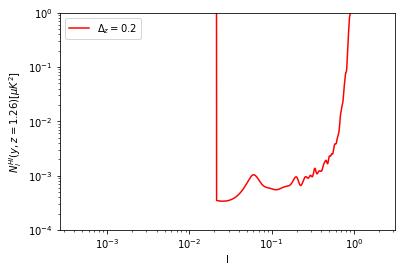

In [13]:
ell_larger=np.geomspace(2.,1.e4,1000)
kperp_larger=ell_larger/chi(z_c)
plt.loglog(kperp_larger,Noise(ell_larger),'r')
#plt.loglog(ell_larger,Hirax_noise_z_1pt26_deltaz_pt0015(ell_larger),'g')
plt.legend((r'$\Delta_z=0.2$',r'$\Delta_z=0.0015$'))
plt.ylim(1.e-4,1.)
#plt.xlim(80,5.e3)
plt.xlabel('l')
plt.ylabel(r'$N_l^{HI}(y,z=1.26)[\mu K^2]$')
#plt.savefig('hirax_noise_z_1pt26_deltaz_pt0015_deltaz_pt2.png')
plt.show()

In [14]:
def PN_integrals_redshift_int(ell,z, z2, y, delta_z, Noise,kp_perp,kp_par):
    
    z1=z

    T_mean=uf.T_mean
    chi_z1=chi(z1)
    f=uf.f
    D=uf.D_1
    r=uf.r
    H=uf.H

    kpar=y/r(z1)

    Noise_kp_perp=Noise(kp_perp*chi(z1))
    '''
    for i in range(len(Noise_kp_perp)):
        if Noise_kp_perp[i]>1.e4:
            Noise_kp_perp[i]=0.
    '''
    #print (Noise_kp_perp.min(),Noise_kp_perp.max(),'Noise of kp perp')
    mock_arr=np.geomspace(2.e-2,6.e-1,n)
    #print (Noise(mock_arr*chi(z1)).min(),Noise(mock_arr*chi(z1)).max(),'Noise of mock arr')
    kp=np.sqrt(kp_perp**2+kp_par**2)
    const=1./(cc.c_light_Mpc_s**2*4*np.pi**2)
    k_perp=ell/chi_z1
    k=np.sqrt(kpar**2+k_perp**2)
    cos_theta=kp_par/kp #cos_theta=u, theta is azimuthal angle between k' and z (line of sight) axis
    sin_theta=kp_perp/kp
    sin_gamma=kpar/k #gamma is measured between k and xy plane, i.e. elevation of k
    cos_gamma=k_perp/k
    zeta=sin_gamma*cos_theta+cos_gamma*sin_theta
    k_dot_kp=k_perp*kp_perp+kpar*kp_par#*zeta
    k_perp_dot_kp_perp=k_perp*kp_perp
    K=np.sqrt(k**2+kp**2-2*k_dot_kp)
    K_perp=np.sqrt(np.abs(k_perp**2+kp_perp**2-2*k_perp_dot_kp_perp))
    #theta_K=kpar/K/k**2*(k**2-k_dot_kp)-kp*k_perp*np.sqrt(np.abs(1-zeta**2))/k/K
    theta_K=(np.abs(kpar-kp_par))/K
    theta_kp=cos_theta
   #theta_K=kpar/k
    mu_k_sq=kpar**2/k**2
    rsd_1=1.+f(z1)*kpar**2/k**2
    rsd_2=1.+f(z2)*kpar**2/k**2
    Noise_Kperp=Noise(K_perp*chi(z1))
    #print (kp_perp.min())
    redshift_PP_z2=T_mean(z2)**2*f(z2)*rsd_2**2*H(z2)*D(z2)**2/(1+z2)
    redshift_PP=T_mean(z1)**2*f(z1)*rsd_1**2*H(z1)*D(z1)**2/(chi(z1)**2*r(z1)*(1+z1))*trapz(redshift_PP_z2,z2)
    redshift_PN_z2=T_mean(z2)*rsd_2*f(z2)*H(z2)*D(z2)/(1+z2)
    redshift_PN=T_mean(z1)*rsd_1*f(z1)*H(z1)*D(z1)/(1+z1)*trapz(redshift_PN_z2,z2)
    redshift_NN_z2=f(z2)*H(z2)/(1+z2)
    redshift_NN=f(z1)*H(z1)*chi(z1)**2*r(z1)/(1+z1)*trapz(redshift_NN_z2,z2)
    
    integrand_P_deldel_P_vv=redshift_PP*kp_perp*theta_kp**2*Mps_interpf(kp)*Mps_interpf(K)/kp**2
    integrand_P_delv_P_delv=redshift_PP*kp_perp*theta_kp*theta_K*Mps_interpf(kp)*Mps_interpf(K)/K/kp
    
    integrand_P_vv_N_deldel=redshift_PN*kp_perp*theta_kp**2*Noise_Kperp*Mps_interpf(kp)/kp**2
    integrand_P_deldel_N_vv=redshift_PN*kp_perp*theta_kp**2 *Noise_kp_perp *Mps_interpf(K)/kp**2
  
    integrand_P_delv_N_delv_1=redshift_PN*kp_perp*theta_kp*theta_K*Noise_kp_perp *Mps_interpf(K)/K/kp
    integrand_P_delv_N_delv_2=redshift_PN*kp_perp*theta_kp*theta_K *Noise_Kperp*Mps_interpf(kp)/K/kp
    
    integrand_N_deldel_N_vv=redshift_NN*kp_perp*theta_kp**2 *Noise_kp_perp*Noise_Kperp/kp**2
    integrand_N_delv_N_delv=redshift_NN*kp_perp*theta_kp*theta_K*Noise_kp_perp*Noise_Kperp/K/kp 


    P_integral_sum=const*(integrand_P_deldel_P_vv+integrand_P_delv_P_delv+integrand_P_vv_N_deldel+integrand_P_deldel_N_vv+integrand_P_delv_N_delv_1+integrand_P_delv_N_delv_2+integrand_N_deldel_N_vv+integrand_N_delv_N_delv)
    #P_integral_sum=const*(integrand_P_deldel_P_vv+integrand_P_delv_P_delv)
    #P_integral_sum=const*(integrand_N_deldel_N_vv+integrand_N_delv_N_delv)
    #P_integral_sum=const*(integrand_P_deldel_N_vv)
    #P_integral_sum=const*(integrand_P_vv_N_deldel+integrand_P_deldel_N_vv+integrand_P_delv_N_delv_1+integrand_P_delv_N_delv_2)
    return P_integral_sum


In [15]:
def SNR_optimal(ell,z,y,delta_z,Noise):
    Kp_perp=np.geomspace(kpperp_min,kpperp_max,n)
    Kp_par=np.geomspace(kppar_min,kppar_max,n)
    z_min=z_c-delta_z
    z_max=z_c+delta_z
    Z_arr=np.geomspace(z_min,z_max,n)
    kp_perp,kp_par,z_arr=np.meshgrid(Kp_perp,Kp_par,Z_arr)
    B=crosscorr_fourier(ell,z,y, delta_z,kp_perp,kp_par)
    Cl_p21_tot=PN_integrals_redshift_int(ell,z,z_arr,y,delta_z, Noise,kp_perp,kp_par)
    Cl_pksz_tot=OV_interp(ell)+cmb_spec_interp(ell)+cmb_noise_interp(ell)
    SNR_sq=B**2/(np.abs(Cl_p21_tot))
    #Cl_pksz_tot_int=sp.integrate.trapz(1./Cl_pksz_tot,ell)
    integral=trapz(trapz(trapz(SNR_sq,Kp_perp,axis=0),Kp_par,axis=0),Z_arr,axis=0)/np.abs(Cl_pksz_tot)
    integral_sqrt=np.sqrt(np.abs(integral))
    return integral_sqrt

In [16]:
z_min=z_c-delta_z
z_max=z_c+delta_z
z_arr=np.geomspace(z_min,z_max,n)

def SNR_optimal_2d(ell,z_c,y,delta_z,Noise):
    return trapz(Func_noise_redshift_slow(ell,z_arr,y,SNR_optimal,delta_z,Noise),z_arr)
    #return Func_noise(ell,z_c,y,SNR_optimal,delta_z,Noise)


In [17]:
3000./uf.chi(z_c)

0.6083850338789202

In [18]:
def SNR_binned(z_c,delta_z,Noise,SNR,Sarea_deg,Dsep):
    z_min=z_c-delta_z
    z_max=z_c+delta_z
    nu_21=1420. #MHz
    nu_min=nu_21/(1+z_max) #743. #585. # #freq in MHz, these min and max values are based on HIRAX
    nu_max=nu_21/(1+z_min) #784. #665. #
    nubar=(nu_min+nu_max)/2.
    cp= HIRAXArrayConfig.from_n_elem_compact(1024,Dsep)
    Fov_str=(cp.fov(frequency=nubar))
    print (Fov_str,'fov')
    Sarea=Sarea_deg*(np.pi/180.)**2 #converting from square degrees to square radians
    print (Sarea,'sarea')
    fsky=Sarea/2./np.pi
    delta_nu_dimless=(nu_max-nu_min)/nu_21
    N_patches=Sarea/Fov_str
    Mode_Volume_Factor=fsky*Sarea*delta_nu_dimless*2
    num_k_bins_y=15
    num_k_bins_ell=15
    n=30
    kpar_arr = np.zeros(num_k_bins_y) ; kperp_arr= np.zeros(num_k_bins_ell) ; SNR_arr = np.zeros((num_k_bins_y,num_k_bins_ell))
    kpar_min = kppar_min
    kpar_max=kppar_max
    kperp_min =kpperp_min
    kperp_max=kpperp_max
    delta_kpar = .01
    delta_kperp = .01
    y_min=kpar_min*r(z_c)
    y_max=kpar_max*r(z_c)
    ell_min=kperp_min*chi(z_c)
    ell_max=kperp_max*chi(z_c)
    delta_y=delta_kpar*r(z_c)
    delta_ell=delta_kperp*chi(z_c)
    y_arr=np.geomspace(y_min,y_max,n)
    kpar_arr_init=np.geomspace(kpar_min,kpar_max,num_k_bins_y+1)
    print kpar_arr_init
    ell_arr=np.geomspace(ell_min,ell_max,n)
    kperp_arr_init=np.geomspace(kperp_min,kperp_max,num_k_bins_ell+1)
    for bin_number_y in range(num_k_bins_y):
        kpar_bin_min, kpar_bin_max = kpar_arr_init[bin_number_y],kpar_arr_init[bin_number_y+1]    # bin_number starts at 0
        #print (kpar_bin_min*r(z),kpar_bin_max*r(z),'kpar')
        for bin_number_ell in range(num_k_bins_ell):
            print bin_number_ell
            kperp_bin_min, kperp_bin_max = kperp_arr_init[bin_number_ell],kperp_arr_init[bin_number_ell+1]
            #print (kperp_bin_min*r(z),kperp_bin_max*r(z),'kperp')
            kpar_arr[np.int(bin_number_y)] = kpar_bin_min  ; kperp_arr[np.int(bin_number_ell)] = kperp_bin_min
            y_bin_arr = y_arr[(y_arr > kpar_bin_min*r(z_c)) & (y_arr < kpar_bin_max*r(z_c))]
            ell_bin_arr = ell_arr[(ell_arr > kperp_bin_min*chi(z_c)) & (ell_arr < kperp_bin_max*chi(z_c))]
            ell_bin_2d_arr=np.outer(ell_bin_arr,np.ones(len(y_bin_arr)))
            #SN_ratio_2d_arr = SNR(ell_bin_arr,y_bin_arr) #SNR(Ell,Y)
            SN_ratio_2d_arr=SNR(ell_bin_arr,z_c,y_bin_arr,delta_z,Noise)
            integrand=SN_ratio_2d_arr**2*ell_bin_2d_arr
            int1=sp.integrate.trapz(integrand, ell_bin_arr, axis=0)
            SNR_sq = 0.5 * Mode_Volume_Factor/(4.*np.pi**2)*N_patches * sp.integrate.trapz(int1, y_bin_arr, axis=0)
            SNR_arr[np.int(bin_number_y),np.int(bin_number_ell)] = np.sqrt(SNR_sq)
                # print 'kparmin=', kpar_bin_min, 'kperpmin=', kperp_bin_min, np.sqrt(SNR_sq)
    return kperp_arr,kpar_arr,SNR_arr


In [19]:
S_area=15000
kperp_arr_snr,kpar_arr_snr,SNR_arr=SNR_binned(z_c, delta_z, Noise,SNR_optimal_2d,S_area,Dsep=7.)

(<Quantity 0.00485392>, 'fov')
(4.5692612968006285, 'sarea')
[1.00000000e-06 2.51188643e-06 6.30957344e-06 1.58489319e-05
 3.98107171e-05 1.00000000e-04 2.51188643e-04 6.30957344e-04
 1.58489319e-03 3.98107171e-03 1.00000000e-02 2.51188643e-02
 6.30957344e-02 1.58489319e-01 3.98107171e-01 1.00000000e+00]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [20]:
print kperp_arr_snr, 'kperp'
print kpar_arr_snr,'kpar'
SNR_arr

[5.00000000e-04 9.67621116e-04 1.87258125e-03 3.62389832e-03
 7.01312107e-03 1.35720881e-02 2.62652780e-02 5.08296753e-02
 9.83677344e-02 1.90365394e-01 3.68403150e-01 7.12949334e-01
 1.37972966e+00 2.67011111e+00 5.16731179e+00] kperp
[1.00000000e-06 2.51188643e-06 6.30957344e-06 1.58489319e-05
 3.98107171e-05 1.00000000e-04 2.51188643e-04 6.30957344e-04
 1.58489319e-03 3.98107171e-03 1.00000000e-02 2.51188643e-02
 6.30957344e-02 1.58489319e-01 3.98107171e-01] kpar


array([[2.26417784e-06, 8.98029505e-06, 3.56617221e-05, 1.33373880e-04,
        3.68375732e-04, 8.09658760e-04, 1.52102175e-03, 1.78623449e-02,
        3.57824491e-02, 8.21299733e-02, 1.67360772e-01, 6.48586330e-02,
        6.98571972e-07, 5.45028561e-09, 2.02850232e-16],
       [3.61250493e-06, 1.43278955e-05, 5.68974662e-05, 2.12794944e-04,
        5.87795664e-04, 1.29175546e-03, 2.42686423e-03, 2.85006564e-02,
        5.70899175e-02, 1.31048540e-01, 2.67036402e-01, 1.03489516e-01,
        1.11456947e-06, 8.69681293e-09, 3.23667533e-16],
       [5.67817228e-06, 2.25188528e-05, 8.94228550e-05, 3.34437791e-04,
        9.24059354e-04, 2.03002428e-03, 3.81461934e-03, 4.47999522e-02,
        8.97242570e-02, 2.06012038e-01, 4.19753506e-01, 1.62686572e-01,
        1.75176362e-06, 1.36725086e-08, 5.08793314e-16],
       [8.56979634e-06, 3.39688316e-05, 1.34873771e-04, 5.04407545e-04,
        1.39475795e-03, 3.06105961e-03, 5.75518311e-03, 6.75979179e-02,
        1.35320325e-01, 3.10924075e-0

0.8455082509526738


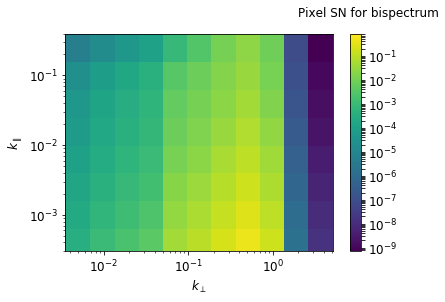

In [21]:
import pylab

#print (np.cumsum(cum_SNR(SNR_arr)))
print SNR_arr.max()

pylab.pcolormesh(kperp_arr_snr,kpar_arr_snr,SNR_arr,norm=LogNorm());  cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
pylab.xlim([np.min(kperp_arr_snr)+.003,np.max(kperp_arr_snr)]) ; pylab.ylim([np.min(kpar_arr_snr)+0.0003,np.max(kpar_arr_snr)])
plt.xlabel(r'$k_\perp$',fontsize=12); plt.ylabel(r'$k_\parallel$',fontsize=12); plt.title('Pixel SN for bispectrum', x=1.13, y=1.05)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('optimal_SN_2D_bispec_z_1pt26_deltaz_pt2_integrated_over_redshift_kpar_1e-3_1_kperp_1e-2_10_zksz_full.png', dpi=300, bbox_inches='tight')
pylab.show()


In [22]:
#np.save('kperp_kpar_z_1_deltaz_pt2_kpar_1e-6_1_kperp_5e-4_10_30by30_70pts',(kperp_arr_snr,kpar_arr_snr))
#np.save('SNR_2d_z_1_deltaz_pt2_kpar_1e-6_1_kperp_5e-4_10_30by30_70pts.npy',(SNR_arr))

In [23]:
def cumulative_SNR(SNR_2D_binned):
    sum_each_kperp=np.array([])
    SNR_y,SNR_x=SNR_2D_binned.shape
    for i in range(SNR_x):
        sum_one_kperp=np.sum(SNR_2D_binned[:,i])
        sum_each_kperp=np.append(sum_each_kperp,sum_one_kperp)
    return sum_each_kperp


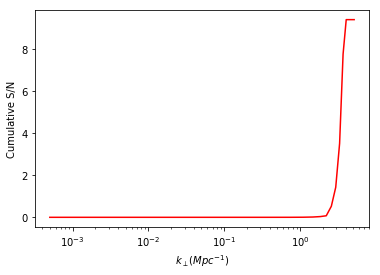

In [24]:
kperp_cumulative=np.linspace(kperp_arr_snr.min(),kperp_arr_snr.max(),len(cumulative_SNR(SNR_arr)))

plt.semilogx(kperp_cumulative,np.cumsum(cumulative_SNR(SNR_arr)),'r')
plt.ylabel('Cumulative S/N')
plt.xlabel(r'$k_\perp (Mpc^{-1})$')
#plt.xlim(1.18e-2,1)
#plt.savefig('optimal_cumSN_2D_bispec_z_1pt26_deltaz_pt2_integrated_over_redshift_kperp_pt01_10_kpar_pt001_1_zksz_full_foregroundcut_and_full.png', dpi=300, bbox_inches='tight')
plt.show()